In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from scipy.ndimage import median_filter
import sys
import os
import struct
import pywt

sys.path.append(os.path.join(os.getcwd(), 'EC'))
import constants
import Func_read_data
import Func_despike_data
import sensor_info
import Func_DR
import Func_MRFD

importlib.reload(Func_read_data)
importlib.reload(Func_despike_data)
importlib.reload(constants)
importlib.reload(sensor_info)
importlib.reload(Func_DR)
importlib.reload(Func_MRFD)

from Func_read_data import *
from constants import *
from Func_despike_data import *
from sensor_info import *
from Func_MRFD import *
from Func_DR import *

In [2]:
folder='/run/user/72637/gvfs/smb-share:server=memobi.wsl.ch,share=pub/Turbulence/PEA/Season_2024-2025/DATA/MET/converted/'
folder='/home/engbers/Documents/PhD/EC_data_convert/converted/'
sensor='SFC'
start='2024-01-01 00:00'
end='2025-03-01 00:00'

"""GET SENSOR INFO"""
plim, calibration_coefficients, heights = get_sensor_info(sensor, 2024)

"""READ FAST AND SLOW DATA from folder"""
slowdata=read_data(folder, 'slow', sensor, start, end, plot_data=False)

/home/engbers/Documents/Github/DataProcessingScripts/Func_read_data.py:272: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'./plots/{sensor}_{start}_slowdata.png', bbox_inches='tight')


(<Figure size 1300x1400 with 7 Axes>,
 array([<Axes: ylabel='Temperature [oC]'>, <Axes: ylabel='RH wrt ice [%]'>,
        <Axes: ylabel='Wind Direction'>, <Axes: ylabel='Wind Speed[ms-1]'>,
        <Axes: ylabel='Net Radiation [Wm-2]'>,
        <Axes: ylabel='Net Radiation [Wm-2]'>,
        <Axes: ylabel='Flowcapt [g/m2/s]'>], dtype=object))

/home/engbers/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


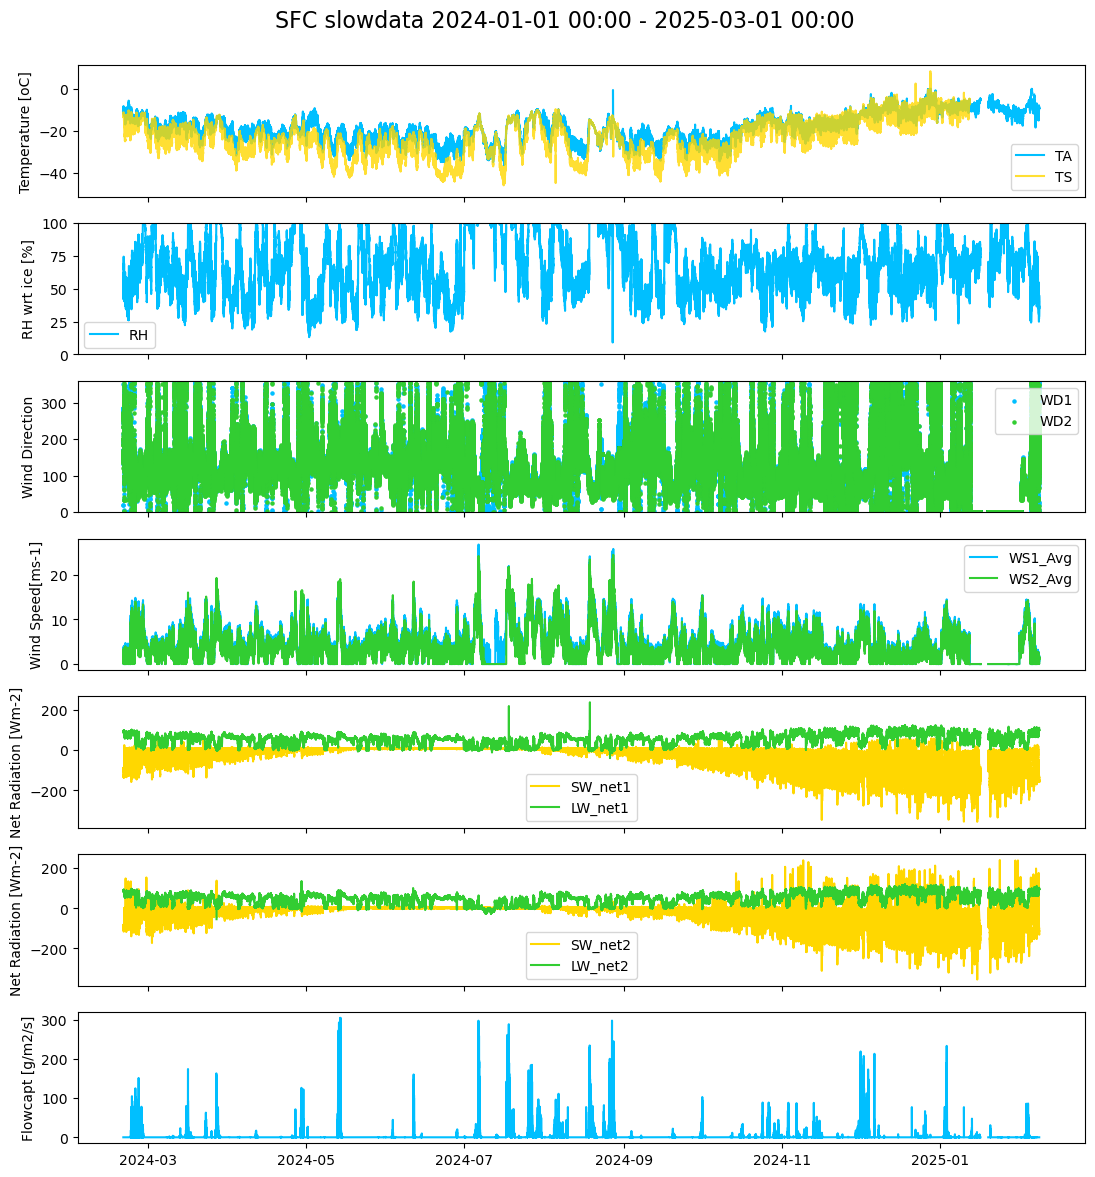

In [12]:
slowdata_cleaned=clean_slowdata(slowdata)
plot_SFC_slowdata(slowdata_cleaned, sensor, start, end)

In [11]:
import glob
folder='/home/engbers/Documents/PhD/EC_data_convert/SFC/202403/'
fastdata_list = []
units_metadata = {}

for file in sorted(glob.glob(folder + '*.dat')):
    temp_data = pd.read_csv(
        file,
        sep='\t',
        index_col=0,
        header=0,
        low_memory=False,
        na_values=['NaN'])
    temp_data.index = pd.to_datetime(temp_data.index, errors='coerce', format='mixed')
    dropped_row = temp_data.iloc[0]  # Extract the first row as metadata
    temp_data = temp_data.iloc[1:]  # Remove the first row from the data
    units_metadata[file] = dropped_row.to_dict()  # Store metadata in a dictionary
    
    # Convert all columns to numeric
    temp_data = temp_data.apply(pd.to_numeric, errors='coerce')
    
    fastdata_list.append(temp_data)  # Add the cleaned DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
fastdata = pd.concat(fastdata_list, ignore_index=False)

# Print the resulting DataFrame
print(fastdata)

                              Ux       Uy       Uz        Ts  LI_H2Om  LI_Pres
2024-03-01 00:00:00.000  0.48250 -2.40475  0.21900 -20.63008     35.9   1831.0
2024-03-01 00:00:00.100  0.24375 -2.55500  0.21825 -20.75847     36.6   1805.0
2024-03-01 00:00:00.200  0.18450 -2.35725  0.08550 -20.63641     36.4   1834.0
2024-03-01 00:00:00.300  0.45625 -2.39325  0.15050 -20.66336     36.1   1860.0
2024-03-01 00:00:00.400  0.66725 -2.33725  0.10750 -20.62689     36.1   1829.0
...                          ...      ...      ...       ...      ...      ...
2024-03-31 23:59:59.500  1.15900 -3.25900  0.14600 -22.77211     20.6   2065.0
2024-03-31 23:59:59.600  1.34400 -3.01650 -0.00975 -22.53528     20.7   2065.0
2024-03-31 23:59:59.700  1.12675 -2.96000 -0.05600 -22.51001     21.2   2089.0
2024-03-31 23:59:59.800  0.71775 -2.75525 -0.08900 -22.49261     20.9   2091.0
2024-03-31 23:59:59.900  1.11875 -2.67950 -0.04650 -22.50684     21.1   2065.0

[26784000 rows x 6 columns]


In [12]:
"""DOUBLE ROTATE THE DATA TO ALIGN WIND VECTOR WITH X-AXIS"""
fastdata_rot, angles=double_rotation(fastdata)


Double rotation for blocks of 0 days 00:30:00


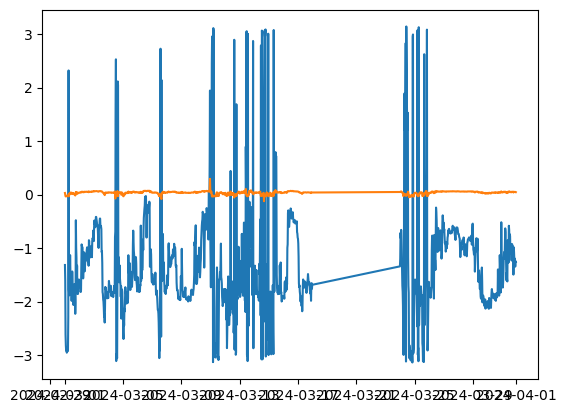

In [8]:
plt.plot(angles)

/home/engbers/Documents/Github/DataProcessingScripts/EC/Func_MRFD.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gaps = pd.concat([gaps, pd.DataFrame({'idx_before_gap': [len(data)],


MRD for DataFrame
Number of gaps: 1


 88%|████████▊ | 878169/1000000 [09:43<01:20, 1504.87it/s]


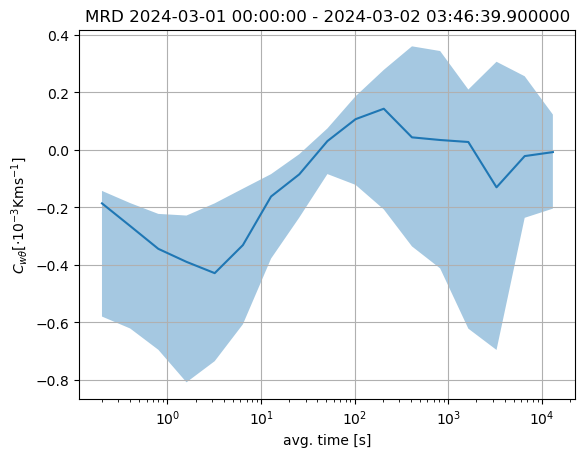

In [5]:
"""DO MRD TO CHECK AVERAGING TIME"""
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[0:1000000], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

MRD for DataFrame
Number of gaps: 1


 88%|████████▊ | 878169/999999 [08:24<01:10, 1739.83it/s]


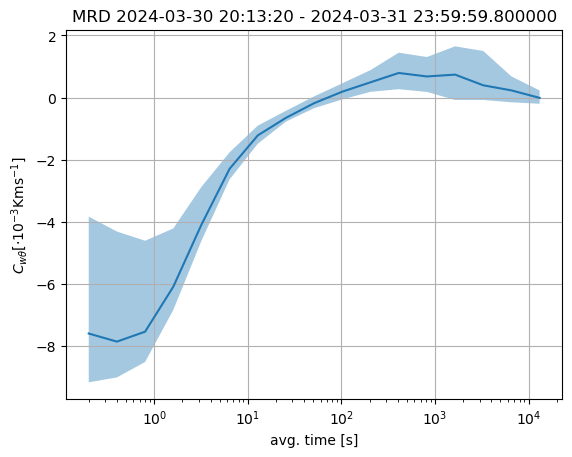

In [6]:
"""DO MRD TO CHECK AVERAGING TIME"""
M=17
(mrd_x, mrd_data, time_middle)=completemrd(fastdata_rot[-1000000:-1], 'Uz', 'Ts', M, shift=round(int(0.1 * 2**M)), plot=True)

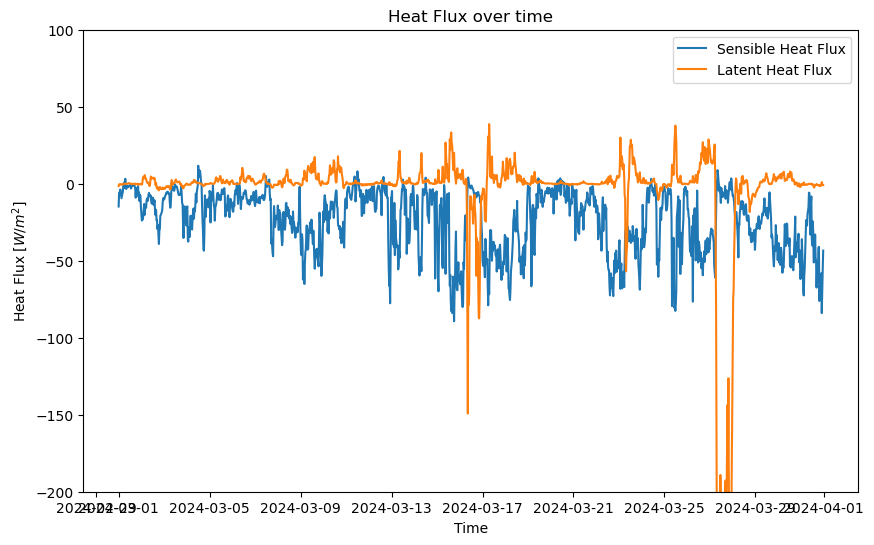

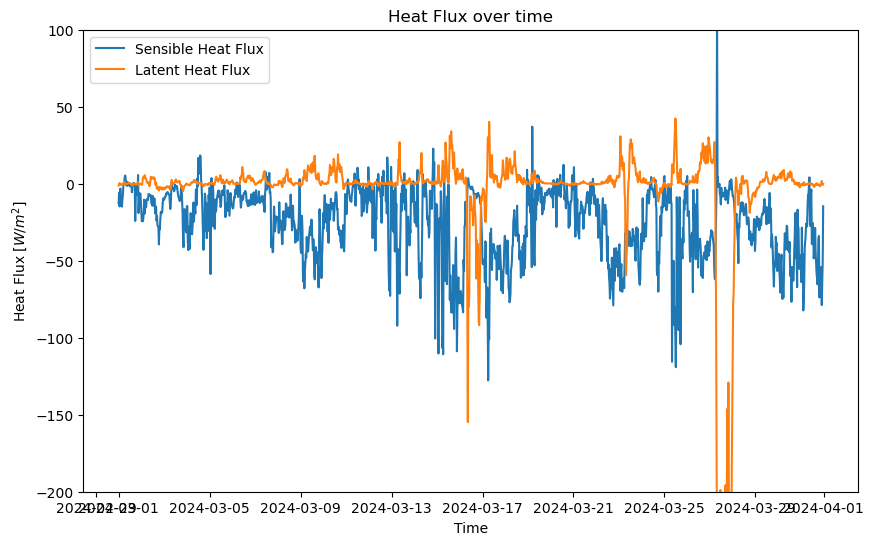

In [13]:
""" CHECK HEATFLUX QUICKLY WITH AVERAGING INTERVAL FOM MRD"""
df_heatflux=check_heat_flux(fastdata_rot, '30s', plot=True)
df_heatflux=check_heat_flux(fastdata_rot, '10min', plot=True)